## Creating a VQ sequence using Kmeans++

Remember to disable Cron so that Controller does not interfere.

In [1]:
import pickle as pk
import numpy as np
from glob import glob
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import sys
sys.path.append('../scripts/lib/')

In [5]:
from shape_utils import *

In [6]:
_size=51
data_dir="/dev/shm/data"

### Load patches of chosend size
Each of the files below is a randomly permuted set of patches. The patches in each file are of a range of 
sizes. Defined by the size of the containing square. Thus `permuted-51.tgz` contains patches whose original square size is in the range (15,51]

In [7]:
!aws s3 ls s3://mousebraindata-open/MD657/permuted/

2018-12-28 01:33:02  351893561 permuted-15.tgz
2018-12-28 01:57:46 2337888441 permuted-151.tgz
2018-12-28 02:00:24  407649744 permuted-201.tgz
2018-12-28 01:39:05 1639192882 permuted-27.tgz
2018-12-28 01:26:24 4656683236 permuted-51.tgz
2018-12-28 01:49:26 3960502846 permuted-81.tgz


In [8]:
tgz_name = 'permuted-%d.tgz'%_size
patch_dir = data_dir+"/permuted-%d"%_size

In [20]:
!aws s3 cp s3://mousebraindata-open/MD657/permuted/$tgz_name $data_dir/$tgz_name

download: s3://mousebraindata-open/MD657/permuted/permuted-51.tgz to ../../../../../dev/shm/data/permuted-51.tgz


In [21]:
!tar xzf $data_dir/$tgz_name -C \/

In [22]:
!ls -lrt /dev/shm/data/

total 11828772
-rw-rw-r-- 1 ubuntu ubuntu 1402470343 Aug 29 04:44 MD657-F95-2017.02.23-18.13.07_MD657_1_0283_lossless.jp2
drwxrwxr-x 2 ubuntu ubuntu       2040 Dec 28 00:57 permuted-51
-rw-rw-r-- 1 ubuntu ubuntu 4656683236 Dec 28 01:26 permuted-51.tgz
drwxrwxr-x 2 ubuntu ubuntu       2040 Dec 28 01:33 permuted-27
-rw-rw-r-- 1 ubuntu ubuntu 1639192882 Dec 28 01:39 permuted-27.tgz
-rw-rw-r-- 1 ubuntu ubuntu 4414297002 Dec 28 17:07 MD657-F95-2017.02.23-18.13.07_MD657_1_0283_lossless.tif
drwxrwxr-x 2 ubuntu ubuntu      12040 Dec 28 17:08 tiles
-rw-rw-r-- 1 ubuntu ubuntu      11431 Dec 28 17:08 MD657-F95-2017.02.23-18.13.07_MD657_1_0283_lossless_patches.tgz


In [9]:
!ls -lh $patch_dir | head
!du -sh $patch_dir

total 37G
-rw-rw-r-- 1 ubuntu ubuntu 375M Dec 28 01:07 permuted0.bin
-rw-rw-r-- 1 ubuntu ubuntu 371M Dec 28 01:07 permuted10.bin
-rw-rw-r-- 1 ubuntu ubuntu 370M Dec 28 01:07 permuted11.bin
-rw-rw-r-- 1 ubuntu ubuntu 369M Dec 28 01:07 permuted12.bin
-rw-rw-r-- 1 ubuntu ubuntu 371M Dec 28 01:07 permuted13.bin
-rw-rw-r-- 1 ubuntu ubuntu 372M Dec 28 01:07 permuted14.bin
-rw-rw-r-- 1 ubuntu ubuntu 369M Dec 28 01:07 permuted15.bin
-rw-rw-r-- 1 ubuntu ubuntu 371M Dec 28 01:07 permuted16.bin
-rw-rw-r-- 1 ubuntu ubuntu 370M Dec 28 01:07 permuted17.bin
37G	/dev/shm/data/permuted-51


In [10]:
from os import system
def run(cmd):
    print('cmd=',cmd)
    system(cmd)

In [11]:
run('touch tmp')
!ls -l tmp

cmd= touch tmp
-rw-rw-r-- 1 ubuntu ubuntu 0 Jan  3 23:12 tmp


In [12]:
def read_files():
    for filename in glob(patch_dir+'/*.bin'):
        D=fromfile(filename,dtype=np.float16)
        print('in read_files filename=%s, shape='%filename,D.shape)
        pics=D.reshape([-1,_size,_size])
        #!rm $data_dir/$filename
        yield pics

In [13]:
def data_stream():
    for pics in read_files():
        for i in range(pics.shape[0]):
            yield pics[i,:,:]

### read 500,000 patches into memory

There are many millions of patches, but we don't need as many to compute the k-means and the diffusion map.

In [14]:
pics_list=[]
i=0
for pic in data_stream():
    pics_list.append(np.array(pic,dtype=np.float32))
    i+=1
    if i>=500000:
        break

    
    

in read_files filename=/dev/shm/data/permuted-51/permuted0.bin, shape= (196157016,)
in read_files filename=/dev/shm/data/permuted-51/permuted1.bin, shape= (194554800,)
in read_files filename=/dev/shm/data/permuted-51/permuted2.bin, shape= (194864319,)
in read_files filename=/dev/shm/data/permuted-51/permuted3.bin, shape= (193438971,)
in read_files filename=/dev/shm/data/permuted-51/permuted4.bin, shape= (192916170,)
in read_files filename=/dev/shm/data/permuted-51/permuted5.bin, shape= (194546997,)
in read_files filename=/dev/shm/data/permuted-51/permuted6.bin, shape= (193030614,)


In [15]:
len(pics_list)

500000

### Show a sample of the patches

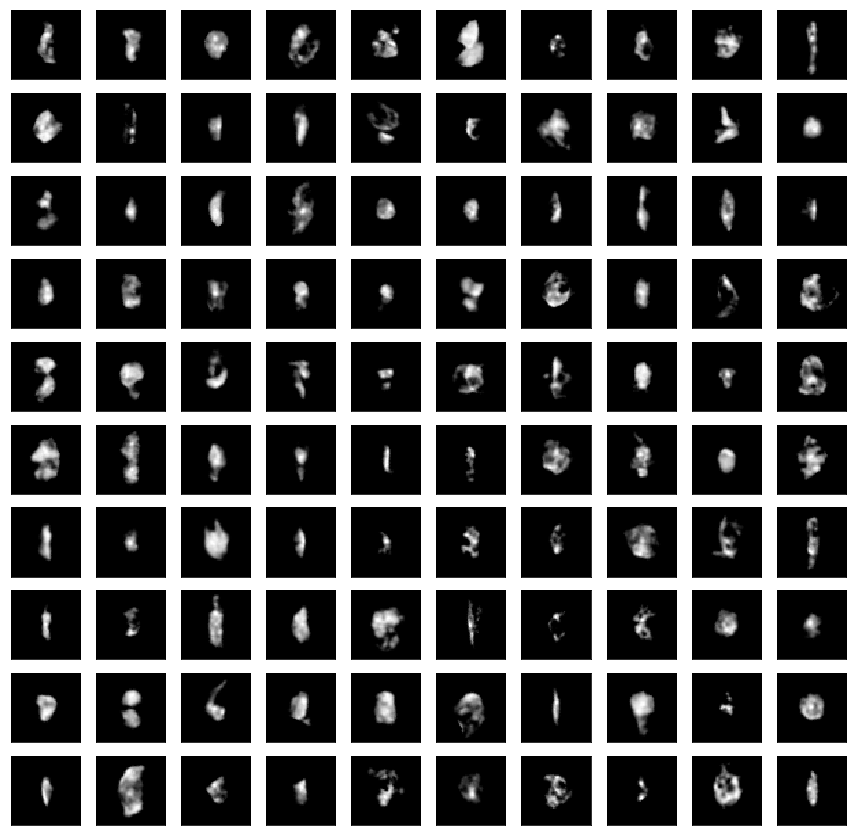

In [16]:
pics=pack_pics(pics_list)
fig=figure(figsize=(15,15))
plot_patches(fig,pics,h=10,w=10)

### Compute the distrbution of the distances between patches.

In [125]:
def dist2(a,b):
    diff=(a-b)**2
    return sum(diff.flatten())

In [18]:
D=[]
for i in range(1,pics.shape[0]):
    D.append(dist2(pics[i,:,:],pics[i-1,:,:]))
    if i%1000==0:
        print('\r',i,end='')

 499000223000

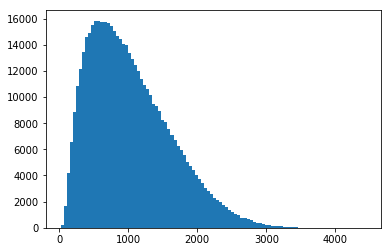

In [19]:
hist(D,bins=100);

In [20]:
max(D)

4433.9511729511105

In [21]:
def refineKmeans(data,Reps):
    new_Reps=[np.zeros(Reps[0].shape) for r in Reps]
    Reps_count=[0.0 for r in Reps]
    error=0
    for i in range(data.shape[0]): 
        patch=data[i,:,:]
        dists=[dist2(patch,r) for r in Reps]
        _argmin=argmin(dists)
        _min=min(dists)
        new_Reps[_argmin]+=patch
        Reps_count[_argmin]+=1
        error+=_min
    error /= data.shape[0]
    final_Reps=[]
    final_counts=[]
    for i in range(len(new_Reps)):
        if Reps_count[i]>5:
            final_Reps.append(new_Reps[i]/Reps_count[i])
            final_counts.append(Reps_count[i])
    return final_Reps,final_counts,error

In [22]:
def Kmeans(data,n=100,scale=550):
    Reps,Statistics = Kmeanspp(data,n,scale)
    for i in range(5):
        Reps,error = refineKmeans(data,Reps)
        print('refine iteration %2d, error=%7.3f'%(i,error))

In [23]:
def Kmeanspp(data,n=100,scale=550):
    Reps=[data[0,:,:]]

    Statistics=[]
    j=1
    for i in range(1,data.shape[0]): 
        _min=100000
        patch=data[i,:,:]
        for r in Reps:
            _min=min(_min,dist2(patch,r))
        Prob=_min/scale
        print('\r','i=%10d,  #reps=%10d  Prob=%8.6f'%(i,len(Reps),Prob),end='')
        Statistics.append((i,len(Reps),_min))
        if np.random.rand()<Prob:
            Reps.append(patch)
            j+=1
        if j>=n:
            break
    return Reps,Statistics

In [24]:
def plot_statistics(Statistics,alpha=0.05,_start=10): 
    N=[x[1] for x in Statistics]
    d=[x[2] for x in Statistics]

    s=mean(d[:_start])
    smoothed=[s]*_start
    for x in d[_start:]:
        s=(1-alpha)*s + alpha*x
        smoothed.append(s)
    loglog(N[_start:],smoothed[_start:])
    xlabel('N')
    ylabel('smoothed distance')
    grid(which='both')

### Run Kmeans++ to generate a given number of samples

In [131]:
N=2000

Reps, Statistics = Kmeanspp(pics,n=N,scale=3000)
Reps_mat = pack_pics(Reps)

 i=       335,  #reps=        51  Prob=0.274099

 i=       537,  #reps=        78  Prob=0.150169

 i=     20033,  #reps=      1999  Prob=0.027049

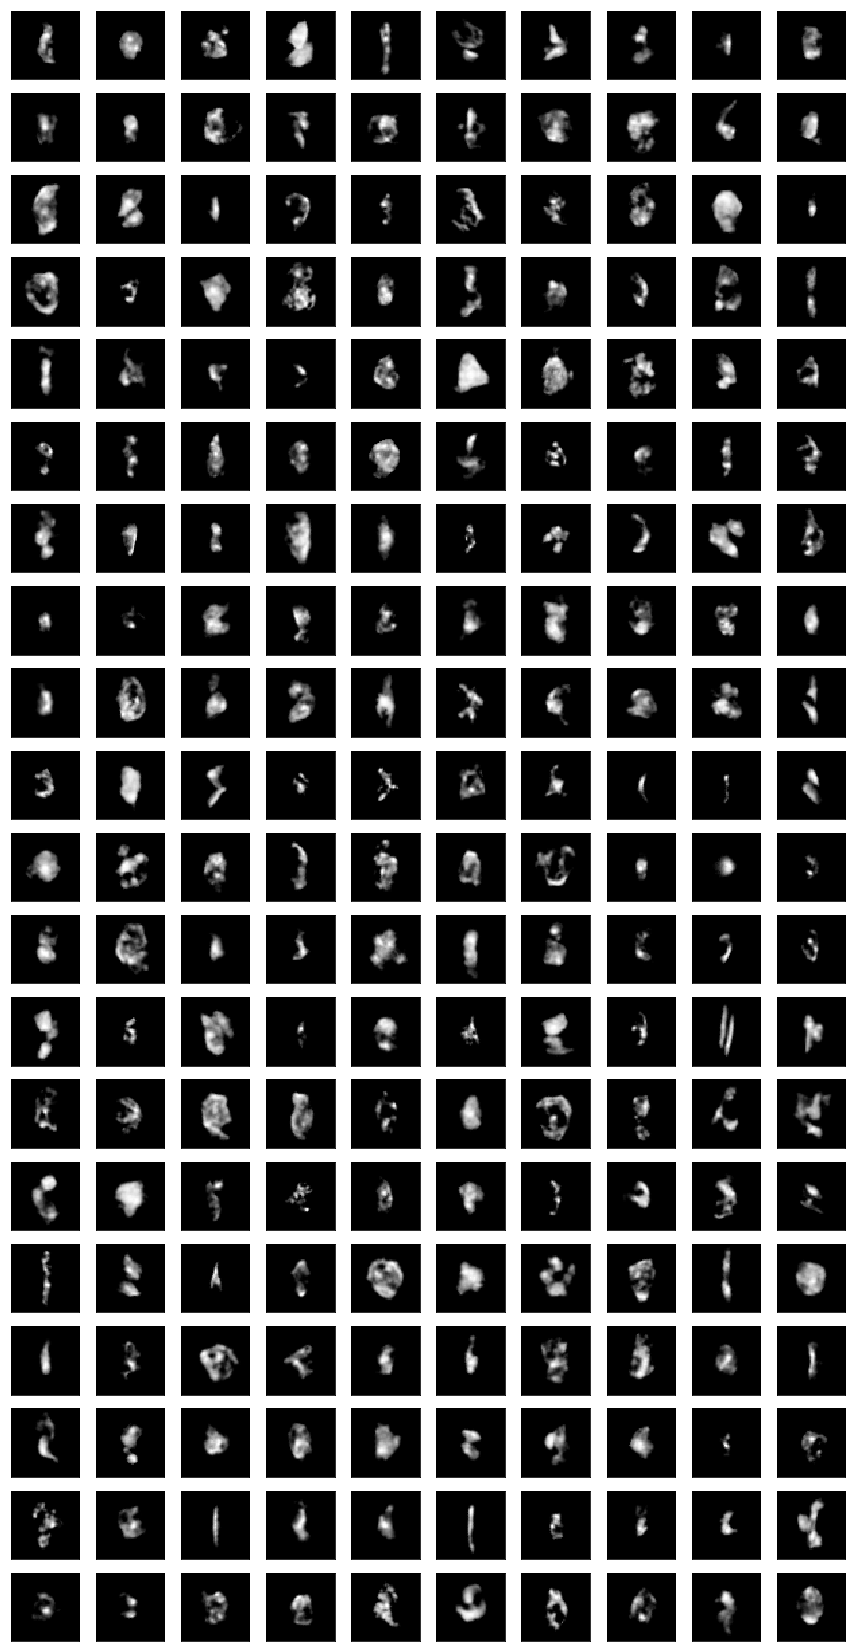

In [132]:
fig=figure(figsize=(15,30))
plot_patches(fig,Reps_mat,h=20,w=10)

In [133]:
Reps_mat.shape

(2000, 51, 51)

### Perform K-means refinement
of the representatives

3 262.93624459128665 1111
4 214.58409539109024 1091
5 211.422976218577 1081
6 209.8712875131714 1072


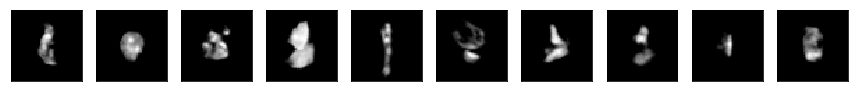

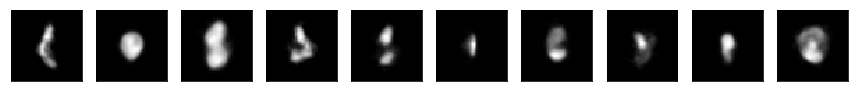

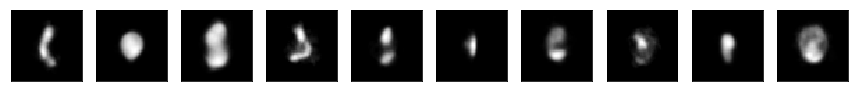

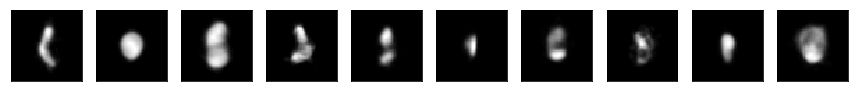

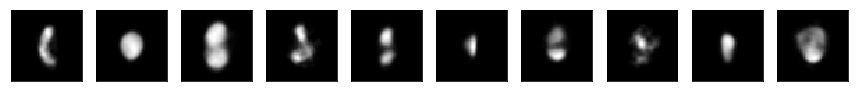

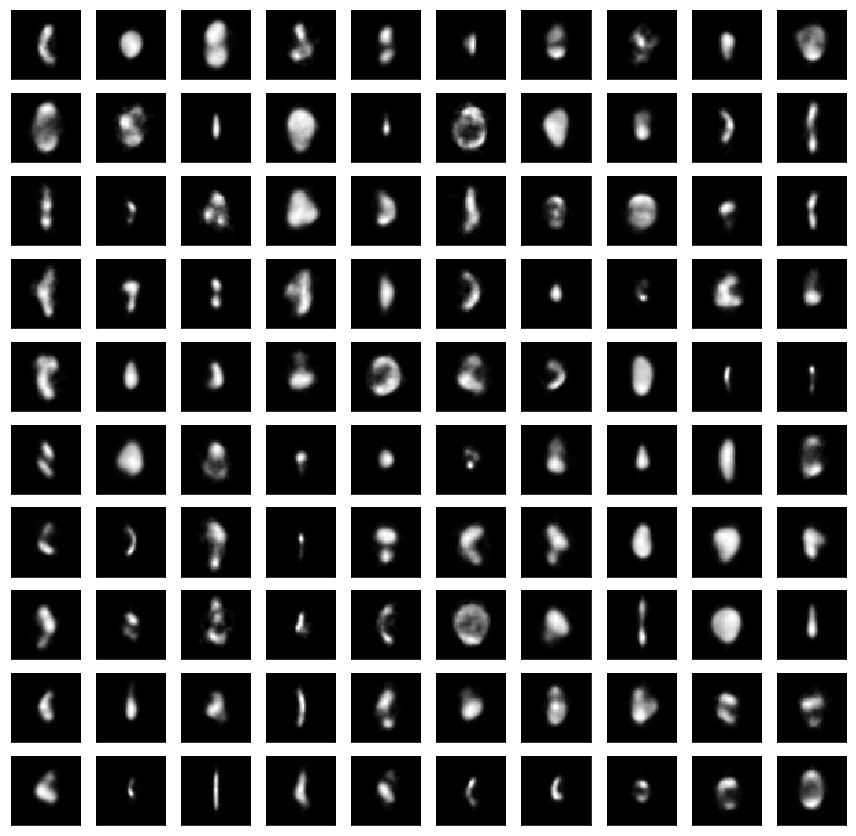

In [135]:
fig=figure(figsize=(15,1.5))
plot_patches(fig,Reps_mat,h=1,w=10) #,_titles=['%4d'%x for x in Reps_count])
for i in range(3,7):
    new_Reps,Reps_count,error = refineKmeans(pics[i*50000:(i+1)*50000,:,:],Reps)
    print(i,error,len(Reps_count))
    Reps_mat = pack_pics(new_Reps)
    fig=figure(figsize=(15,1.5))
    plot_patches(fig,Reps_mat,h=1,w=10) #,_titles=['%4d'%x for x in Reps_count])
    Reps=new_Reps
fig=figure(figsize=(15,15))
plot_patches(fig,Reps_mat,h=10,w=10) #,_titles=['final_%4d'%x for x in Reps_count])

## Calculate diffusion map

The matrix corresponds to a simple random walk on the individual examples  where the location of each example is replaced by the location of the corresponding representative. 

We use [pydiffmap](https://pydiffmap.readthedocs.io/en/master/)

In [136]:
L=len(new_Reps)
new_Reps[0].shape
data1D=np.concatenate([x.reshape([1,_size*_size]) for x in new_Reps])
data1D.shape

(1072, 2601)

Text(0.5,1,'distances between centroids')

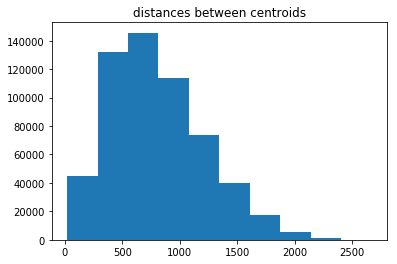

In [137]:
dists=[]
for i in range(L):
    for j in range(i):
        dists.append(dist2(new_Reps[i],new_Reps[j]))
hist(dists);
title('distances between centroids')

In [138]:
from pydiffmap import diffusion_map as dm
# initialize Diffusion map object.
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}

mydmap = dm.DiffusionMap(n_evecs=50, k=20, epsilon=500.0, alpha=1.0, neighbor_params=neighbor_params)
# fit to data and return the diffusion map.
dmap = mydmap.fit_transform(data1D)

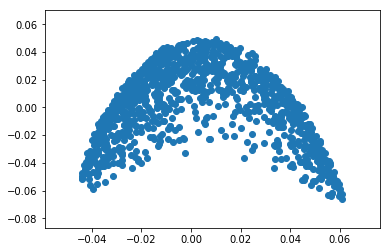

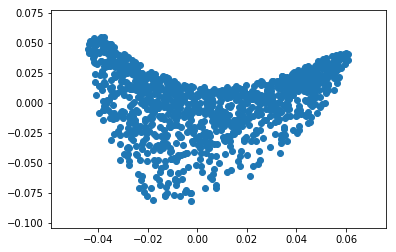

In [139]:
pylab.scatter(dmap[:,0],dmap[:,1]);
figure()
pylab.scatter(dmap[:,0],dmap[:,2]);

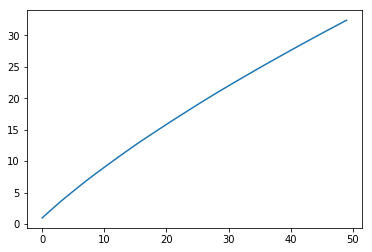

In [140]:
plot(cumsum(mydmap.evals));

Text(0.5,1,'no. of examples per partition')

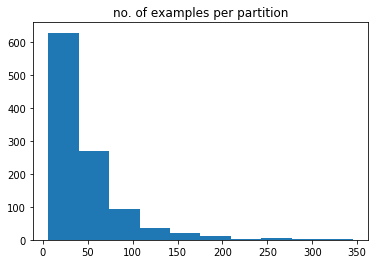

In [141]:
hist(Reps_count);
title('no. of examples per partition')

### Create Scatter Images

In [142]:
def scatter_images(pics,dmap,d1=0,d2=1,canvas_sz=1000):
    canvas_size=np.array([canvas_sz,canvas_sz])
    _minx=min(dmap[:,d1])
    _maxx=max(dmap[:,d1])
    _miny=min(dmap[:,d2])
    _maxy=max(dmap[:,d2])
    shift_x = -_minx
    scale_x = canvas_size[0]/(_maxx - _minx)
    shift_y = -_miny
    scale_y = canvas_size[1]/(_maxy - _miny)

    x=[int((_x+shift_x)*scale_x) for _x in dmap[:,d1]]
    y=[int((_y+shift_y)*scale_y) for _y in dmap[:,d2]]

    image_size=np.array(pics.shape[1:])
    canvas=2*np.ones(canvas_size+image_size)
    for i in range(pics.shape[0]):
        canvas[x[i]:x[i]+image_size[0],y[i]:y[i]+image_size[1]]=pics[i,:,:]
    return canvas

### Create a scatter-plot of the representative patches

In [143]:
Rep_pics=pack_pics(new_Reps)

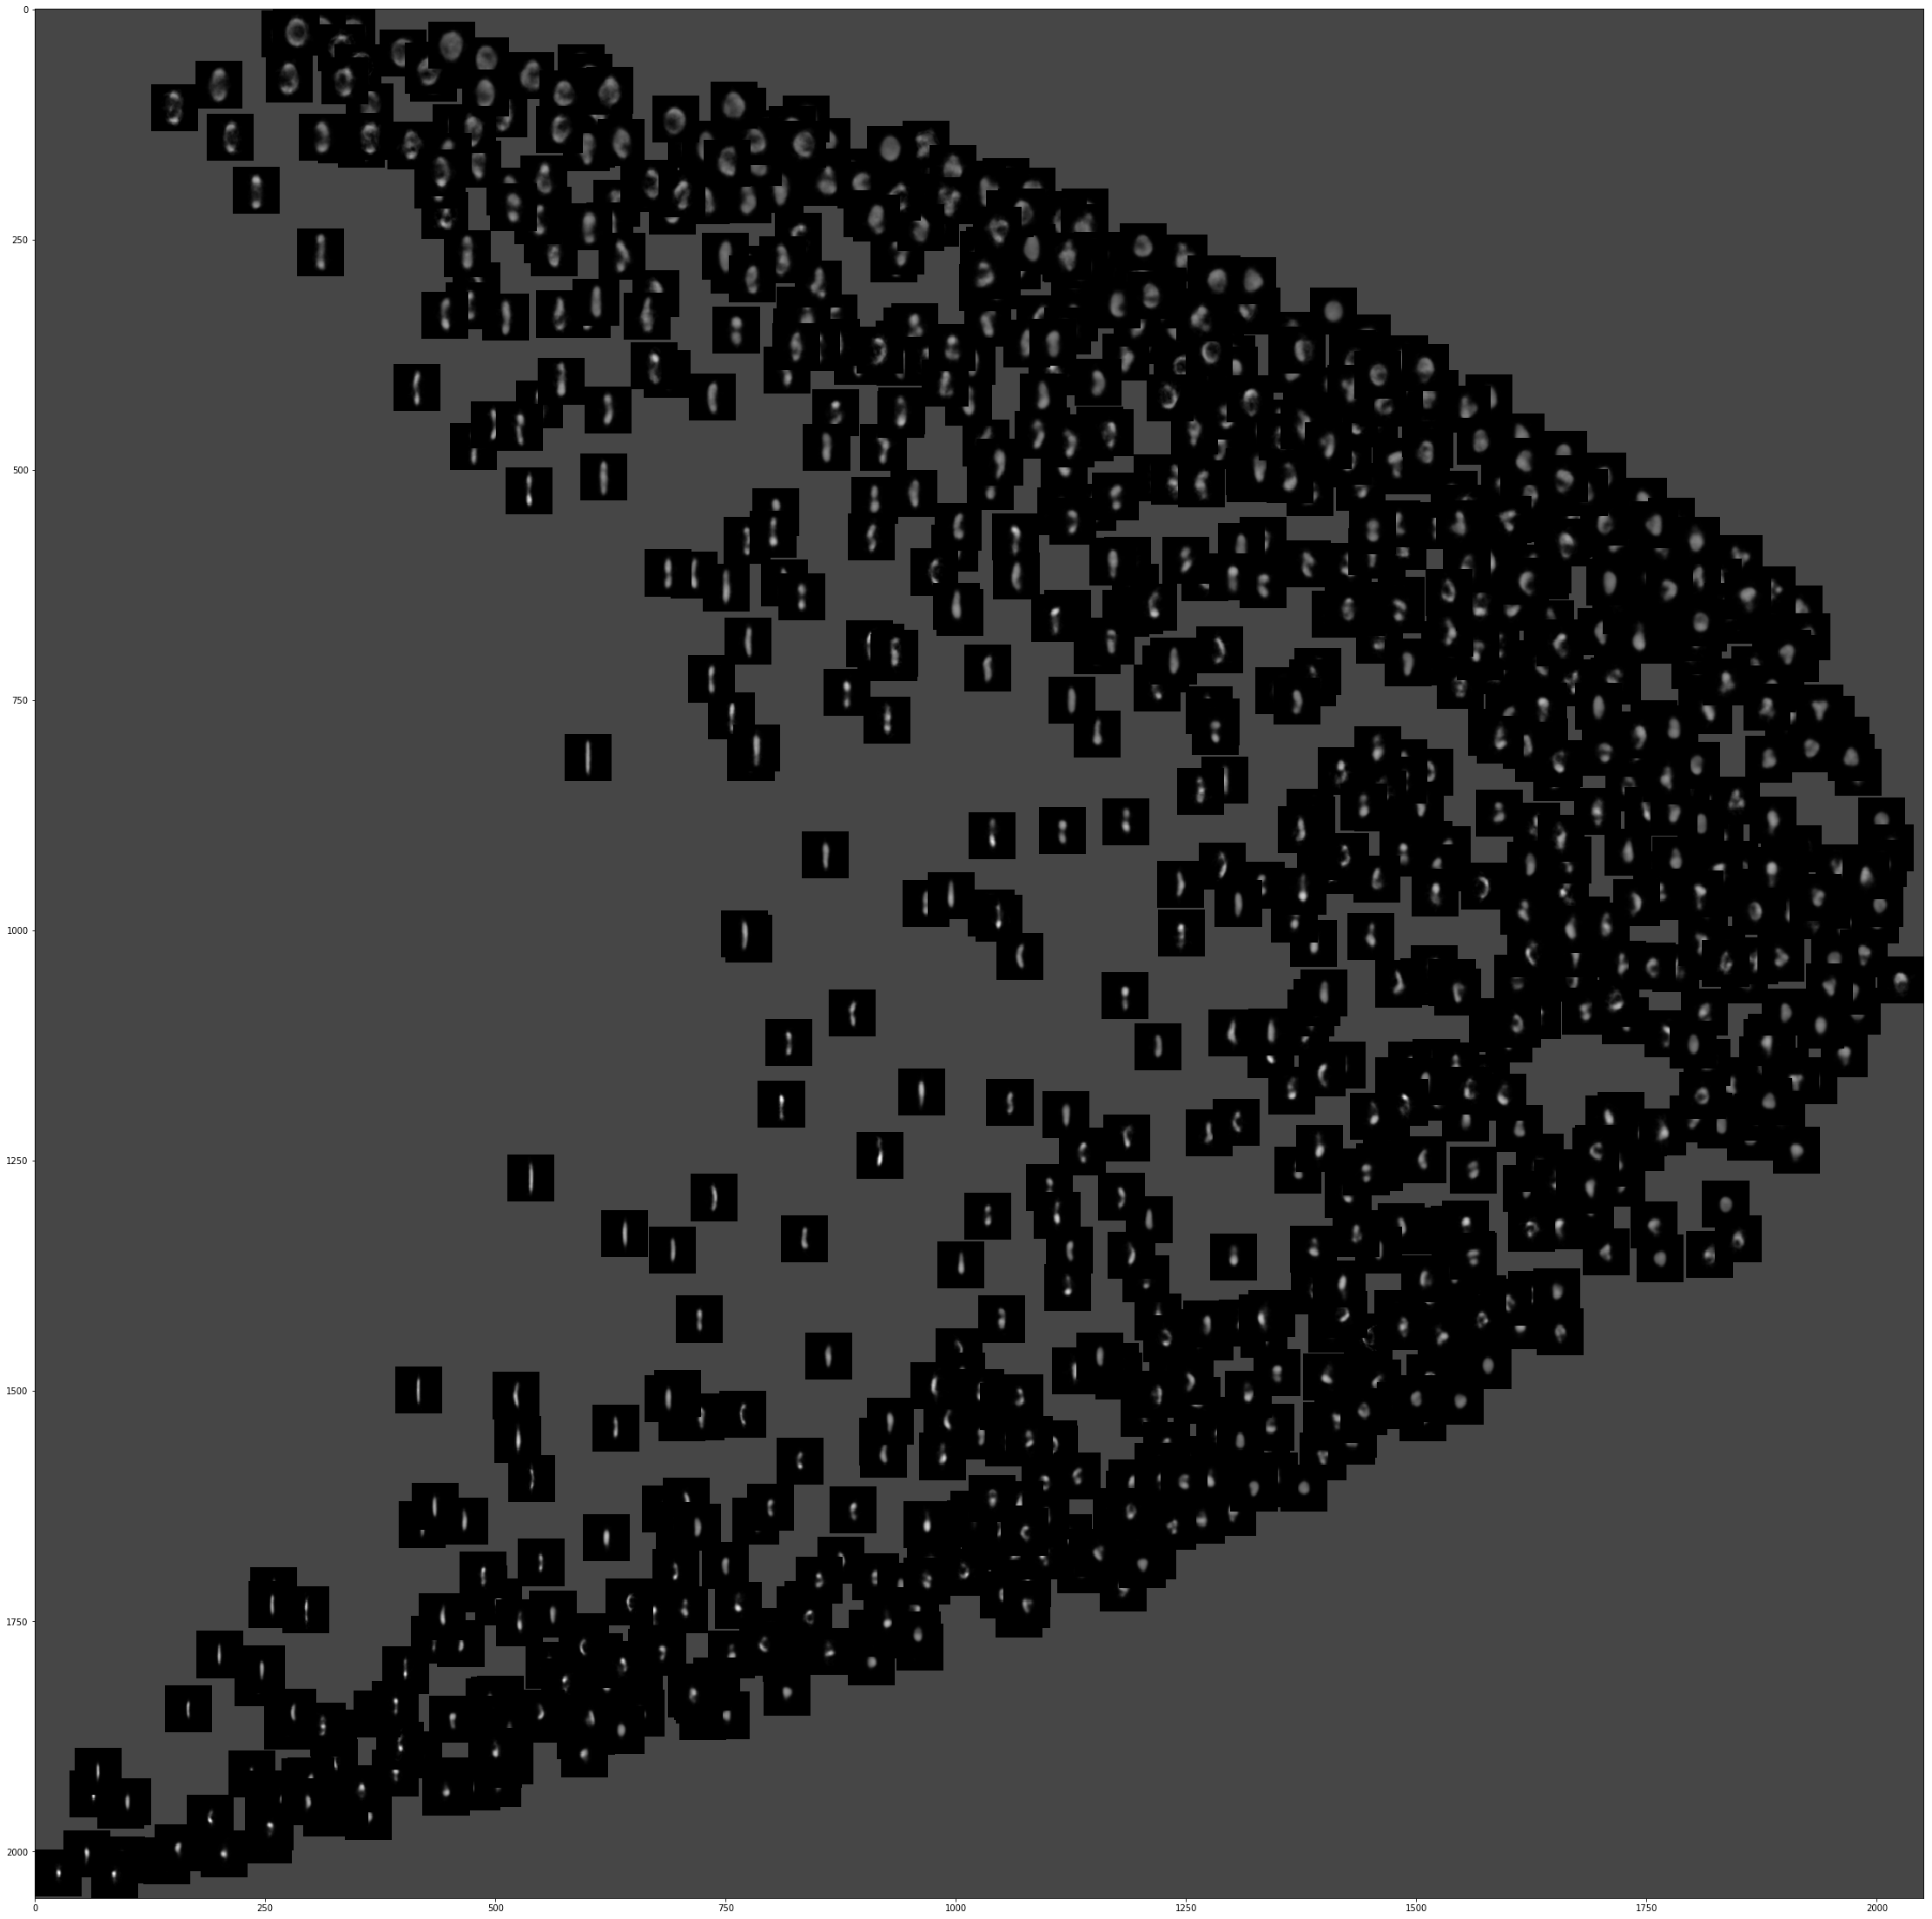

In [144]:
figure(figsize=[40,40])
canvas=scatter_images(Rep_pics,dmap,d1=0,d2=1,canvas_sz=2000)
imshow(canvas,cmap='gray');
imwrite('Reps01.tiff',canvas);

### Transform raw patches and create scatter plots for them

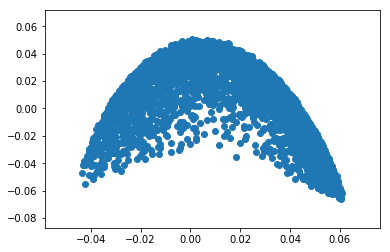

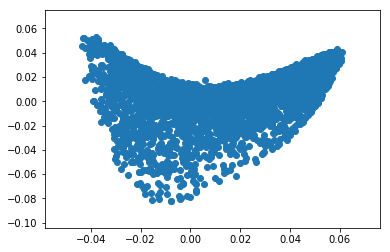

In [145]:
some_pics=pics[1000:4000,:,:]
data=some_pics.reshape([-1,_size*_size])
data.shape

dmap = mydmap.transform(data)

pylab.scatter(dmap[:,0],dmap[:,1]);
figure()
pylab.scatter(dmap[:,0],dmap[:,2]);

In [146]:
dmap.shape

(3000, 50)

In [147]:
from cv2 import imwrite
#imwrite?

In [149]:
!rm -rf scatterplots
!mkdir scatterplots

In [150]:
for d1 in range(5):
    for d2 in range(d1+1,8):
        #print(d1,d2)
        canvas=scatter_images(some_pics,dmap,d1,d2,canvas_sz=10000)
        imwrite('scatterplots/scatter%d%d.tiff'%(d1,d2),canvas);

In [151]:
!aws s3 cp --recursive scatterplots/ s3://mousebraindata-open/MD657/scatterplots/

upload: scatterplots/scatter06.tiff to s3://mousebraindata-open/MD657/scatterplots/scatter06.tiff
upload: scatterplots/scatter01.tiff to s3://mousebraindata-open/MD657/scatterplots/scatter01.tiff
upload: scatterplots/scatter02.tiff to s3://mousebraindata-open/MD657/scatterplots/scatter02.tiff
upload: scatterplots/scatter12.tiff to s3://mousebraindata-open/MD657/scatterplots/scatter12.tiff
upload: scatterplots/scatter03.tiff to s3://mousebraindata-open/MD657/scatterplots/scatter03.tiff
upload: scatterplots/scatter07.tiff to s3://mousebraindata-open/MD657/scatterplots/scatter07.tiff
upload: scatterplots/scatter13.tiff to s3://mousebraindata-open/MD657/scatterplots/scatter13.tiff
upload: scatterplots/scatter04.tiff to s3://mousebraindata-open/MD657/scatterplots/scatter04.tiff
upload: scatterplots/scatter05.tiff to s3://mousebraindata-open/MD657/scatterplots/scatter05.tiff
upload: scatterplots/scatter15.tiff to s3://mousebraindata-open/MD657/scatterplots/scatter15.tiff
upload: scatterplots

In [152]:
im=imread('scatterplots/scatter12.tiff')
im.shape

/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2546: DecompressionBombWarning: Image size (101022601 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


(10051, 10051)

In [153]:
type(im[0,0])

numpy.uint8

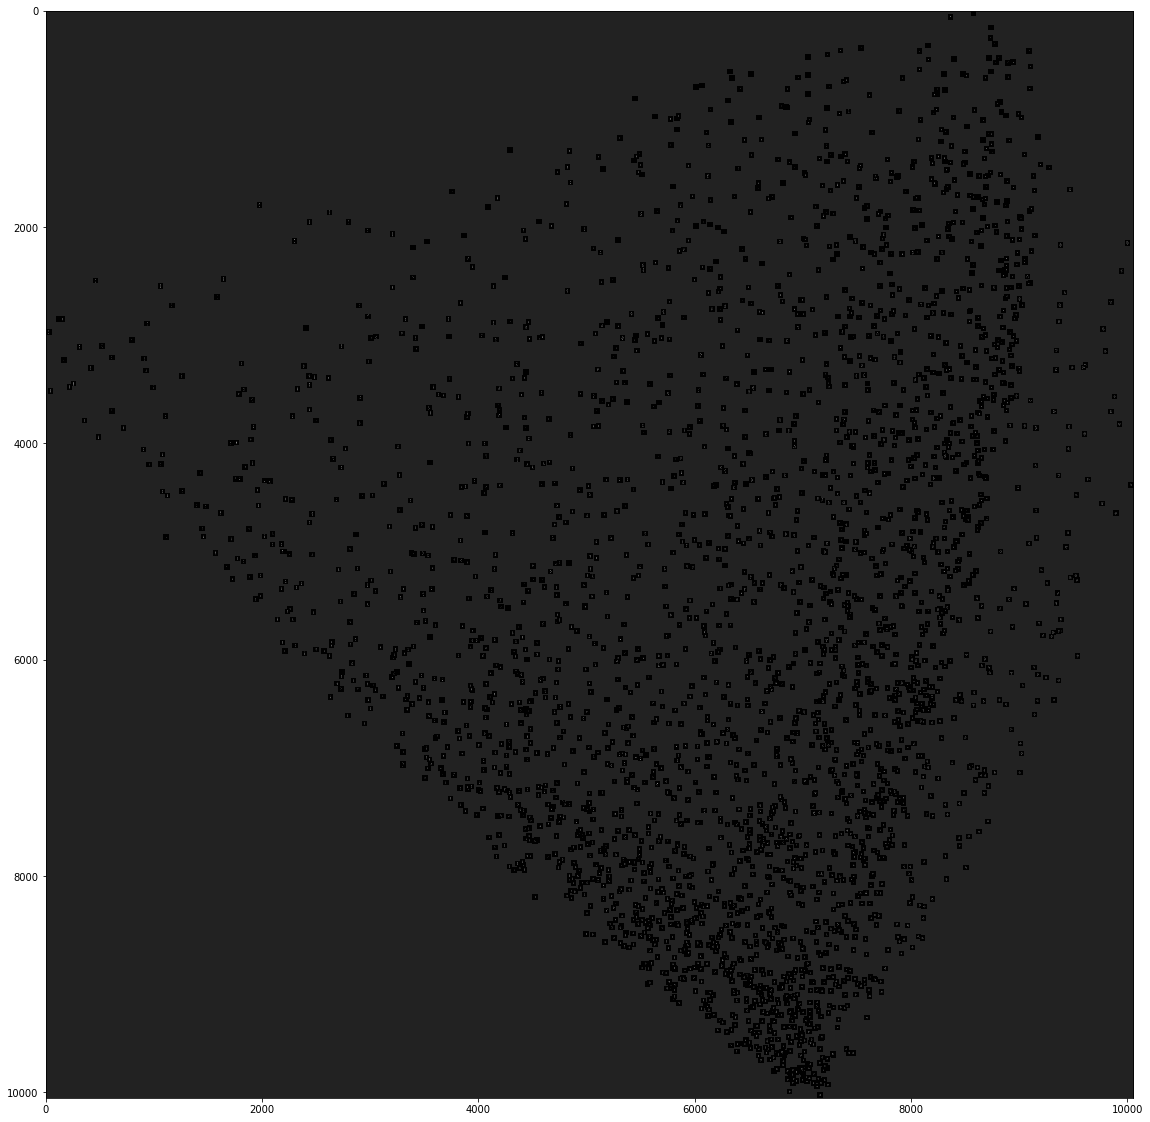

In [154]:
figure(figsize=(20,20))
imshow(im,cmap='gray');

In [119]:
!ls -lh scatterplots/

rm: cannot remove 'scatter??.*': No such file or directory
total 62M
-rw-rw-r-- 1 ubuntu ubuntu 2.4M Jan  4 02:19 scatter01.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter02.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter03.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter04.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.6M Jan  4 02:19 scatter05.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter06.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter07.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter12.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter13.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.6M Jan  4 02:19 scatter14.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.6M Jan  4 02:19 scatter15.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.6M Jan  4 02:19 scatter16.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.6M Jan  4 02:19 scatter17.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter23.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M Jan  4 02:19 scatter24.tiff
-rw-rw-r-- 1 ubuntu ubuntu 2.5M

### Save diffusion map as a pickle file

In [155]:
from pickle import dump
dump(mydmap,open('diffusionMap.pkl','wb'))

In [156]:
!ls -lh *.pkl

-rw-rw-r-- 1 ubuntu ubuntu 25M Jan  4 19:56 diffusionMap.pkl


In [157]:
!aws s3 cp diffusionMap.pkl  s3://mousebraindata-open/MD657/DiffusionMaps/diffusionMap.pkl

upload: ./diffusionMap.pkl to s3://mousebraindata-open/MD657/DiffusionMaps/diffusionMap.pkl


### Odds and ends

In [ ]:
from pydiffmap.visualization import embedding_plot, data_plot
data_plot?

In [ ]:
embedding_plot(mydmap, scatter_kwargs = {'c': dmap[:,2], 'cmap': 'Spectral'})
#data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})

plt.show()

In [ ]:
A=np.zeros([L,L])
for i in range(L):
    for j in range(L):
        w=exp(-dist2(new_Reps[i],new_Reps[j])/sigma2)
        A[i,j]=w * Reps_count[i]*Reps_count[j]

In [ ]:
D=sum(A,axis=0)
D2=diag(1/sqrt(D))

NA=np.dot(D2,np.dot(A,D2))

w,v = np.linalg.eig(NA)
hist(NA.flatten(),bins=100);

In [ ]:
i=0
print('eig no %3d eigval=%5.3f'%(i,w[i]))
sorted_v=sort(v[i,:])
order=argsort(v[i,:])
plot_patches(Reps_mat[order],h=10,w=10,_titles=['c_%1d=%6.3f'%(i,x) for x in sorted_v])

In [ ]:
plot(w[:10])

In [ ]:
scatter(v[1,:],v[2,:])

In [ ]:
v[2,:]